<a href="https://colab.research.google.com/github/wentaoy/CIS519_Project/blob/master/alzheimer_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import pandas as pd
from torch import nn
from time import time
from os import path
from torchvision import transforms
import random
from copy import deepcopy
import urllib.request
import ssl
import tarfile

In [ ]:
# import MRI image dataset, and we will use preprocess image 
gcontext = ssl.SSLContext()
dataseturl = "https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz" 
fstream = urllib.request.urlopen(dataseturl, context=gcontext)
tarfile = tarfile.open(fileobj=fstream, mode="r:gz")
tarfile.extractall()

   participant_id session_id alternative_id_1  ...   MMS  cdr_global  diagnosis
0  sub-OASIS10001    ses-M00    OAS1_0001_MR1  ...  29.0         0.0         CN
1  sub-OASIS10002    ses-M00    OAS1_0002_MR1  ...  29.0         0.0         CN
2  sub-OASIS10003    ses-M00    OAS1_0003_MR1  ...  27.0         0.5         AD
3  sub-OASIS10004    ses-M00    OAS1_0004_MR1  ...  30.0         NaN         CN
4  sub-OASIS10005    ses-M00    OAS1_0005_MR1  ...  30.0         NaN         CN

[5 rows x 12 columns]


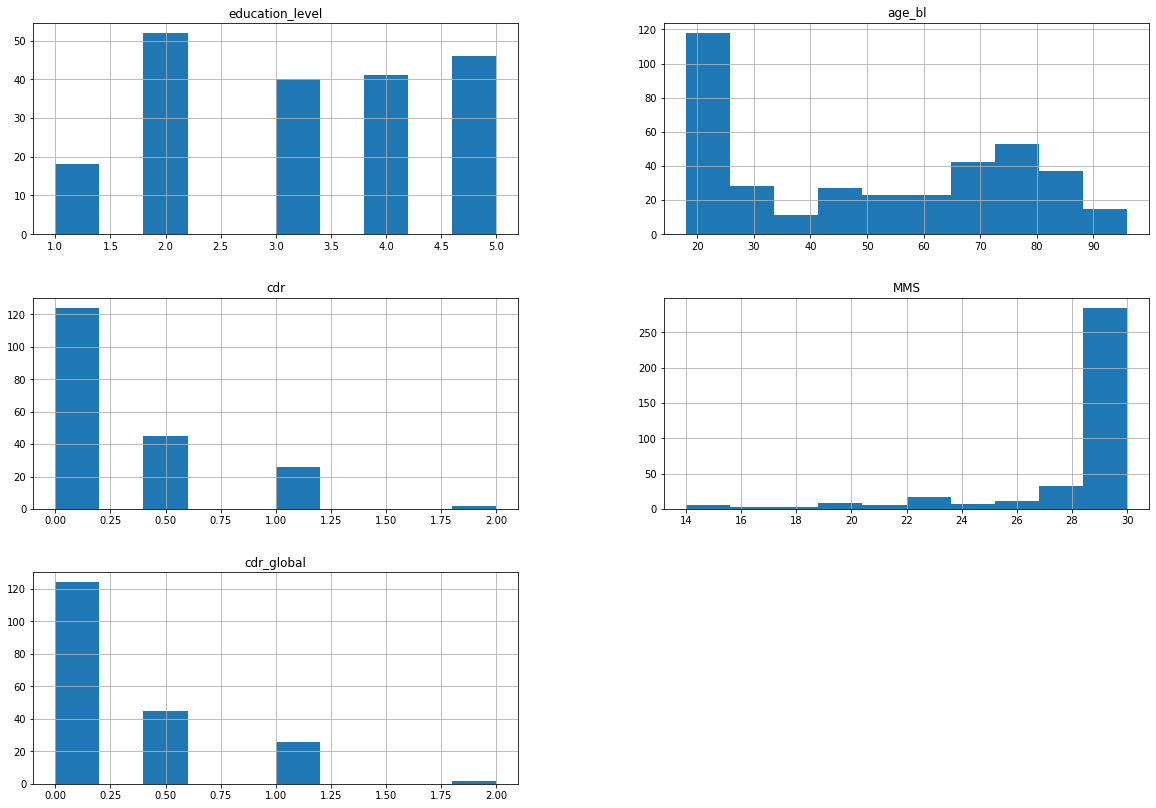

In [ ]:
# Load the complete dataset
OASIS_df = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/OASIS_BIDS.tsv', sep='\t')
# Show first items of the table
print(OASIS_df.head())
# First visual inspection
_ = OASIS_df.hist(figsize=(20, 14))

Define torch dataset to load MRI images and their labels in OASIS_BIDS.tsv

In [ ]:
from torch.utils.data import Dataset, DataLoader, sampler
from os import path
import torchvision.transforms as transforms

LABEL_NAMES = {"AD": 1, "CN": 0}
class MRIDataset(Dataset):
    def __init__(self, image_path, dataframe, data_transforms=None):
        """
        Args:
          dataframe (string): Path to the OASIS_tsv file.
          image_path (string): Directory with all the images.
          transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataframe = dataframe
        self.image_path = image_path
        self.data_transforms = data_transforms

    def __len__(self):
        """
        return the size of dataset
        """
        return len(self.dataframe)
        
        

    def __getitem__(self, idx):
        """
        return a tuple: (image, label) 
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #get participant_id and session_id
        participant_id = self.dataframe.loc[idx, 'participant_id']
        session_id = self.dataframe.loc[idx, 'session_id']

        #get image
        filename = 'subjects/' + participant_id + '/' + session_id + '/' + \
          'deeplearning_prepare_data/image_based/custom/' + \
          participant_id + '_' + session_id + \
          '_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt'
        image = torch.load(path.join(self.image_path, filename))

        #get label and convert it into binary
        image_label = self.dataframe.loc[idx, 'diagnosis']
        label = LABEL_NAMES[image_label]

        if self.data_transforms:
            image = self.data_transforms(image)

        image_map = (image, label)
        return image_map

    def train(self):
        self.data_transforms.train()

    def eval(self):
        self.data_transforms.eval()


In [ ]:
class CropLeftHC(object):
    """Crops the left hippocampus of a MRI non-linearly registered to MNI"""
    def __init__(self, random_shift=0):
        self.random_shift = random_shift
        self.train_mode = True
    def __call__(self, img):
        if self.train_mode:
            x = random.randint(-self.random_shift, self.random_shift)
            y = random.randint(-self.random_shift, self.random_shift)
            z = random.randint(-self.random_shift, self.random_shift)
        else:
            x, y, z = 0, 0, 0
        return img[:, 25 + x:55 + x,
                   50 + y:90 + y,
                   27 + z:57 + z].clone()

    def train(self):
        self.train_mode = True

    def eval(self):
        self.train_mode = False


In [ ]:
img_dir = path.join('OASIS-1_dataset', 'CAPS')
batch_size=10

example_dataset = MRIDataset(img_dir, OASIS_df)
example_dataloader = DataLoader(example_dataset, batch_size=batch_size, drop_last=True)
for data in example_dataloader:
    pass

print(f"Shape of Dataset output:\n {example_dataset[0][0].shape}\n")

# print(f"Shape of DataLoader output:\n {data['image'].shape}")

Shape of Dataset output:
 torch.Size([1, 121, 145, 121])



In [ ]:
# DO NOT TOUCH THIS CELL!
def init_weights(net):
    """
    Usage: net = Model()
           net.apply(init_weights)
    """
    for m in net.modules():
        if isinstance(m, nn.Conv3d):
            nn.init.kaiming_normal_(m.weight)
        elif isinstance(m, nn.BatchNorm3d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
#             if m.bias is not None:
#                 stdv = 1. / math.sqrt(m.weight.size(1))
#                 nn.init.uniform_(m.bias, -stdv, stdv)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class ADClassifier(torch.nn.Module):
  def __init__(self):
        """
        """
        # Don't remove the following line. Otherwise, it would raise ```AttributeError: cannot assign module before Module.__init__() call``` exception ERROR!
        super(ADClassifier, self).__init__() 
        
        self.convolutions = nn.Sequential(
            nn.Conv3d(1, 8, 3, padding=1),
            nn.BatchNorm3d(8),
            nn.LeakyReLU(),
            nn.MaxPool3d(2, 2),
            nn.Conv3d(8, 16, 3, padding=1),
            nn.BatchNorm3d(16),
            nn.LeakyReLU(),
            nn.MaxPool3d(2, 2),
            nn.Conv3d(16, 32, 3, padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(),
            nn.MaxPool3d(2, 2)
        )
        self.linear = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(129600, 2)
      )

  def forward(self, x):
        x = self.convolutions(x)
        x = torch.flatten(x,1)
        # print(x.shape)
        x = self.linear(x)
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class AD_LEFTHC_Classifier(torch.nn.Module):
  def __init__(self):
        """
        """
        # Don't remove the following line. Otherwise, it would raise ```AttributeError: cannot assign module before Module.__init__() call``` exception ERROR!
        super(AD_LEFTHC_Classifier, self).__init__() 
        
        self.convolutions = nn.Sequential(
            nn.Conv3d(1, 8, 3, padding=1),
            nn.BatchNorm3d(8),
            nn.LeakyReLU(),
            nn.MaxPool3d(2, 2),
            nn.Conv3d(8, 16, 3, padding=1),
            nn.BatchNorm3d(16),
            nn.LeakyReLU(),
            nn.MaxPool3d(2, 2),
            nn.Conv3d(16, 32, 3, padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(),
            nn.MaxPool3d(2, 2)
        )
        self.linear = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(1440, 2)
      )

  def forward(self, x):
        x = self.convolutions(x)
        x = torch.flatten(x,1)
        # print(x.shape)
        x = self.linear(x)
        return x

In [ ]:
def load_data(image_path, dataset_path, data_transforms=None, num_workers=0, batch_size=4):
    dataset = MRIDataset(image_path,dataset_path,data_transforms)
    print("this is image shape", dataset[0][0].shape)
    return DataLoader(dataset, num_workers=num_workers, batch_size=batch_size, shuffle=True)

In [ ]:
# DO NOT TOUCH THIS CELL!
import numpy as np
from torchvision.transforms import functional as TF

def accuracy(outputs, labels):
    # outputs_idx = outputs.max(1)[1].type_as(labels)
    # return outputs_idx.eq(labels).float().mean()
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def predict(model, data, device='cpu'):
    data = data.to(device)
    logits = model(data)
    return F.softmax(logits, -1)

def draw_bar(axis, preds, labels=None):
    y_pos = np.arange(6)
    axis.barh(y_pos, preds, align='center', alpha=0.5)
    axis.set_xticks(np.linspace(0, 1, 10))
    
    if labels:
        axis.set_yticks(y_pos)
        axis.set_yticklabels(labels)
    else:
        axis.get_yaxis().set_visible(False)
    
    axis.get_xaxis().set_visible(False)

def visualize_predictions(model=None, model_name=None, device_name='cpu'):
  
    if model is not None:
        model.eval()
    else:
        model = load_model(model_name, device_name)
    
    # Get the device 
    if device_name is not None:
        device = torch.device(device_name)
    model = model.to(device)

    validation_image_path='./data/valid' #enter the path 

    dataset = SuperTuxDataset(image_path=validation_image_path)

    f, axes = plt.subplots(2, 6)

    idxes = np.random.randint(0, len(dataset), size=6)

    for i, idx in enumerate(idxes):
        img, label = dataset[idx]
        preds = predict(model, img[None], device=device).detach().cpu().numpy()

        axes[0, i].imshow(TF.to_pil_image(img))
        axes[0, i].axis('off')
        draw_bar(axes[1, i], preds[0], LABEL_ if i == 0 else None)

    plt.show()

def validation_step(model, batch, loss_function):
      images, labels = batch 
      images = images.to(device)
      labels = labels.to(device)
      out = model(images)                    # Generate predictions
      loss = loss_function(out, labels)   # Calculate loss
      acc = accuracy(out, labels)           # Calculate accuracy
      return {'val_loss': loss.detach(), 'val_acc': acc}
        
def validation_epoch_end(model, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
def epoch_end(model, epoch, result):
  print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

def evaluate(model, val_loader, loss_function):
    outputs = [validation_step(model, batch, loss_function) for batch in val_loader]
    return validation_epoch_end(model,outputs)

In [ ]:
class Args(object):
    pass

args = Args();
args.learning_rate = 0.0001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_batch(args, model,device,train_loader, optimizer, loss,epoch):
  model.train()
  total_loss = 0
  for batch_index, (data,target) in enumerate(train_loader,0):
    #map data and label to the device
    data, target = data.to(device), target.to(device)
    #flush out all old gradients
    optimizer.zero_grad()
    #run forward pass model.forward(data)
    # print("this is data", data.shape)
    output = model(data) 
    #loss computation
    loss_function = loss(output,target)
    total_loss += loss_function.item()
    #full gradient computation
    loss_function.backward()
    #update all parameters
    optimizer.step()
  return total_loss
  

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

def train(args, model_name="ADClassifier"):

  img_dir = path.join('OASIS-1_dataset', 'CAPS')
  train_df = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')
  valid_df = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/validation.tsv', sep='\t')

  if model_name == "AD_LEFTHC_Classifier":
    print("lefthc model")
    model = AD_LEFTHC_Classifier().to(device)
    model.apply(init_weights)
    train_loader = load_data(img_dir, train_df, data_transforms=CropLeftHC())
    valid_loader = load_data(img_dir, valid_df, data_transforms=CropLeftHC())
  else:
    model = ADClassifier().to(device)
    model.apply(init_weights)
    train_loader = load_data(img_dir, train_df)
    valid_loader = load_data(img_dir, valid_df)
  # train_iter = iter(train_loader)
  # images, labels = train_iter.next()
  # print('images shape on batch size = {}'.format(images.size()))
  # print('labels shape on batch size = {}'.format(labels.size()))
  

  learning_rate = 0.006
  loss = nn.CrossEntropyLoss(reduction='mean')
  # optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
  #optimizer = optim.SGD(model.parameters(), lr=0.006, momentum=0.9)
  optimizer = torch.optim.Adam(model.parameters(), learning_rate)
  scheduler = StepLR(optimizer, step_size = 5, gamma = 0.1)

    #forward process 
  total_accuracy = 0

  for epoch in range(1,10):
      
    train_batch(args,model,device, train_loader,optimizer, loss, epoch)
    scheduler.step() #update base learning

      #evaluate on validation set
    result = evaluate(model, valid_loader,loss)
    total_accuracy += result['val_acc']

    # print(type(result), result)
    epoch_end(model,epoch, result)
  print("this is average accuracy", total_accuracy / 11) 
      #check if performance is better
        # best_model = deepcopy(model)
        # save_model(model, model_name)

In [ ]:
train(args)
    

this is image shape torch.Size([1, 121, 145, 121])
this is image shape torch.Size([1, 121, 145, 121])
Epoch [1], val_loss: 22.3561, val_acc: 0.7500
Epoch [2], val_loss: 8.5666, val_acc: 0.8375
Epoch [3], val_loss: 14.9562, val_acc: 0.8375
Epoch [4], val_loss: 3.6858, val_acc: 0.9000
Epoch [5], val_loss: 6.5995, val_acc: 0.8250
Epoch [6], val_loss: 5.4097, val_acc: 0.8500
Epoch [7], val_loss: 3.6746, val_acc: 0.9000
Epoch [8], val_loss: 5.2611, val_acc: 0.8500
Epoch [9], val_loss: 3.0588, val_acc: 0.8625
Epoch [10], val_loss: 3.2545, val_acc: 0.8625
Epoch [11], val_loss: 3.0729, val_acc: 0.8625
this is average accuracy 0.8488636341961947


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
img_dir = path.join('OASIS-1_dataset', 'CAPS')


train_df = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')
valid_df = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/validation.tsv', sep='\t')

train_datasetLeftHC = MRIDataset(img_dir, train_df)
valid_datasetLeftHC = MRIDataset(img_dir, valid_df)

# Try different learning rates
learning_rate = 10**-4
n_epochs = 30
batch_size = 4

# Put the network on GPU
modelLeftHC = ADClassifier().cuda()
train_loaderLeftHC = DataLoader(train_datasetLeftHC, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
# A high batch size improves test speed
valid_loaderLeftHC = DataLoader(valid_datasetLeftHC, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(modelLeftHC.parameters(), learning_rate)

best_modelLeftHC = train(modelLeftHC, train_loaderLeftHC, criterion, optimizer, n_epochs)

valid_resultsLeftHC_df, valid_metricsLeftHC = test(best_modelLeftHC, valid_loaderLeftHC, criterion)
train_resultsLeftHC_df, train_metricsLeftHC = test(best_modelLeftHC, train_loaderLeftHC, criterion)
print(valid_metricsLeftHC)
print(train_metricsLeftHC)

image withou transformation: 7minutes with 10 epoch 
image with transformation: 11s with 10 epoch 